In [ ]:
# Import necessary libraries
import os
import copy
import time
import math
import torch
import random
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
###################  NOTE ###################
# download the " Neural_Network_Controller.pth " and " System_Identification_Model.pth " from the repo and put them in the following path
# /content/drive/MyDrive/

Mounted at /content/drive


In [ ]:
# Define a function to set random seeds for reproducibility across different libraries.
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
# Define and test the NeuralPlant model
class NeuralPlant(nn.Module):
    # Initialize the plant model's neural network architecture and the simulation environment
    def __init__(self, path = None):
        super(NeuralPlant, self).__init__()
        self.model = nn.Sequential(
                nn.Conv1d(in_channels= 2, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(64 * 150, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 32),
                nn.ReLU(),
                nn.Linear(32, 2)
            )
        self.model.eval()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(self.device)
        if(path is not None):
          self.Load_model(path)
        self.dt = 0.01
        self.max_vel  = 20
        self.max_volt = 12.4
        self.input_seq = torch.zeros((1, 150, 2), dtype=torch.float32).to(self.device)
        self.output = torch.zeros((2,), dtype=torch.float32).to(self.device)

    # Load pre-trained model weights
    def Load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location = torch.device(self.device), weights_only=True))
        self.model.eval()

    # Simulate one step of the plant with a given input voltage
    def step(self, input_voltage):
        input_voltage = torch.reshape(input_voltage, (1, 2)).to(self.device)
        input_voltage = torch.clamp(input_voltage, -self.max_volt, self.max_volt)
        self.input_seq = torch.cat((self.input_seq[:, 1:, :], torch.unsqueeze(input_voltage, dim=0)), dim=1)
        self.output = self.model(self.input_seq.permute(0,2,1))[0]
        return self.output

    # Simulate the open-loop response of the plant to a sequence of input voltages
    def open_loop_response(self, input_voltage):
        self.reset()
        out = []
        for ind in range(input_voltage.shape[0]):
            out_step = self.step(input_voltage[ind])
            out.append(out_step)
        return torch.stack(out)

    # Reset the plant's internal state
    def reset(self):
        self.input_seq = torch.zeros((1, 150, 2), dtype=torch.float32).to(self.device)
        self.output = torch.zeros((2,), dtype=torch.float32).to(self.device)

    # Test the open-loop response of the plant with random inputs
    def test_response(self):
        Vr = torch.rand((2,), dtype=torch.float32).to(self.device) * 12
        Vr = Vr.unsqueeze(1).repeat(1, 150)
        Vl = torch.rand((2,), dtype=torch.float32).to(self.device) * 12
        Vl = Vl.unsqueeze(1).repeat(1, 150)
        input_voltage = torch.stack([Vl.reshape(-1), Vr.reshape(-1)], axis=1)
        y_out = self.open_loop_response(input_voltage)

        plt.plot(np.arange(len(input_voltage[:, 0].cpu()))*self.dt,input_voltage[:, 0].cpu(), label='Vl')
        plt.plot(np.arange(len(input_voltage[:, 1].cpu()))*self.dt,input_voltage[:, 1].cpu(), label='Vr')
        plt.plot(np.arange(len(y_out[:, 0].cpu()))*self.dt,y_out[:, 0].detach().cpu().numpy(), label='wl')
        plt.plot(np.arange(len(y_out[:, 1].cpu()))*self.dt,y_out[:, 1].detach().cpu().numpy(), label='wr')
        plt.legend()
        plt.show()

#plant = NeuralPlant('/content/drive/MyDrive/System_Identification_Model.pth')

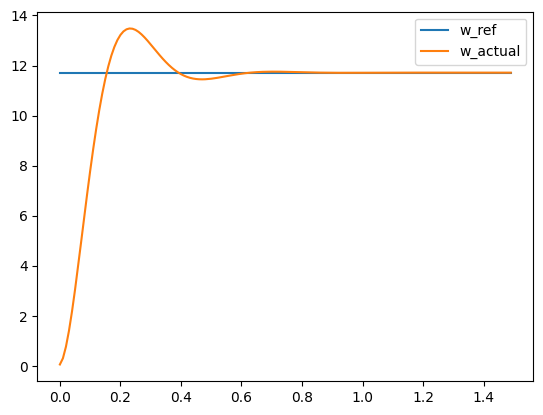

In [ ]:
# Define and test the ModelReference for desired system behavior
class ModelReference:
    # Initialize the model reference with desired damping and natural frequency
    def __init__(self, Ts = 0.5, Mp=0.15, dt=0.01):
        ln_mp = np.log(Mp)
        zeta = -ln_mp / np.sqrt(np.pi ** 2 + ln_mp ** 2)
        wn = 4 / (zeta * Ts)
        num = [wn ** 2]
        den = [1, 2 * zeta * wn, wn ** 2]
        sys_cont = signal.TransferFunction(num, den)
        self.dt = dt
        self.sys = signal.cont2discrete((sys_cont.num, sys_cont.den), dt, method='tustin')

    # Calculate the model's response to a given reference input
    def response(self, ref):
        _, output = signal.dlsim(self.sys, ref.numpy())
        return torch.from_numpy(output).flatten()

    # Test the model's response with a random reference input
    def test_response(self):
        ref = torch.full((150,), (12.0 * torch.rand(1)).item())
        y_out = self.response(ref)
        plt.plot(np.arange(len(ref))*self.dt, ref.numpy(), label='w_ref')
        plt.plot(np.arange(len(y_out))*self.dt, y_out.numpy() ,label='w_actual')
        plt.legend()
        plt.show()

model_ref = ModelReference()
model_ref.test_response()

In [ ]:
# Define the Neural Network Controller class
class NN_Controller(nn.Module):
    # Initialize the neural network controller
    def __init__(self, max_ref, model=None):
        super(NN_Controller, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = nn.Sequential(
            nn.Linear(198, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32),  nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 2)).to(self.device)

        if model is not None:
            self.Load_model(model)

        self.best_model = copy.deepcopy(self.model)
        self.best_model.load_state_dict(self.model.state_dict())
        self.training_data, self.validation_data, self.testing_data = self.generate_dataset(max_ref)
        self.loss = nn.HuberLoss(delta=1.0, reduction='mean')

        self.batch_size = 64
        self.epochs = 100
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.005)

    # Load pre-trained model weights
    def Load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location = torch.device(self.device), weights_only=True))
        self.model.eval()

    # Generate training, validation, and testing datasets
    def generate_dataset(self, max_ref):
        data_set_left = torch.rand(800).to(self.device) * max_ref
        data_set_right = torch.rand(800).to(self.device) * max_ref
        data_set = torch.stack([data_set_left, data_set_right], axis=1).to(self.device)
        N_train = int(0.7 * len(data_set))
        N_val = int(0.2 * len(data_set))
        training_data = data_set[:N_train]
        validation_data = data_set[N_train:N_train + N_val]
        testing_data = data_set[N_train + N_val:]
        return training_data, validation_data, testing_data

In [ ]:
# Define the Closed_Loop_System class for training and testing
class Closed_Loop_System:
    # Initialize the closed-loop system with plant, controller, and model reference
    def __init__(self, model = None):
        self.plant = NeuralPlant('/content/drive/MyDrive/System_Identification_Model.pth')
        self.controller = NN_Controller(self.plant.max_vel, model)
        self.model_reference = ModelReference()
        self.device = self.plant.device
        self.dt = 0.01
        self.history_size = 49
        self.left_error_history_R = torch.zeros((1, self.history_size + 1), dtype=torch.float32).to(self.device)
        self.right_error_history_R = torch.zeros((1, self.history_size + 1), dtype=torch.float32).to(self.device)
        self.left_voltage_history = torch.zeros((1, self.history_size), dtype=torch.float32).to(self.device)
        self.right_voltage_history = torch.zeros((1, self.history_size), dtype=torch.float32).to(self.device)
        self.controller_vector = torch.zeros((1, 2*(self.history_size + 1) + 2*self.history_size), dtype=torch.float32).to(self.device)
        self.step_count = 0


    # Reset the entire closed-loop system to its initial state
    def reset_system(self):
        self.plant.reset()
        self.left_error_history_R = torch.zeros((1, self.history_size + 1), dtype=torch.float32).to(self.device)
        self.right_error_history_R = torch.zeros((1, self.history_size + 1), dtype=torch.float32).to(self.device)
        self.left_voltage_history = torch.zeros((1, self.history_size), dtype=torch.float32).to(self.device)
        self.right_voltage_history = torch.zeros((1, self.history_size), dtype=torch.float32).to(self.device)
        self.controller_vector = torch.zeros((1, 2*(self.history_size + 1) + 2*self.history_size), dtype=torch.float32).to(self.device)
        self.step_count = 0

    # Update the historical data for errors and voltage commands
    def update_history(self, voltage_commands, y_pred_last, refs_last):
        self.step_count += 1
        if self.step_count % 3 == 0:
            self.left_error_history_R = torch.cat([self.left_error_history_R[:, 1:], torch.unsqueeze(refs_last[0] - y_pred_last[0], 0).unsqueeze(0)], axis=1)
            self.right_error_history_R = torch.cat([self.right_error_history_R[:, 1:], torch.unsqueeze(refs_last[1] - y_pred_last[1], 0).unsqueeze(0)], axis=1)
            self.left_voltage_history = torch.cat([self.left_voltage_history[:, 1:], torch.unsqueeze(voltage_commands[0, 0], 0).unsqueeze(0)], axis=1)
            self.right_voltage_history = torch.cat([self.right_voltage_history[:, 1:], torch.unsqueeze(voltage_commands[1, 0], 0).unsqueeze(0)], axis=1)


    # Update the input vector for the controller based on history
    def update_controller_vector(self):
        self.controller_vector = torch.cat([self.left_error_history_R, self.right_error_history_R, self.left_voltage_history, self.right_voltage_history], axis=1)


    # Train the neural network controller
    def train_controller(self):
        train_losses, val_losses = [], []
        best_val_loss = float('inf')
        for epoch in range(self.controller.epochs):
            for ind in range(int(self.controller.training_data.shape[0]//self.controller.batch_size)):
              refs = self.generate_batch_data(self.controller.training_data[ind*self.controller.batch_size: (ind+1)*self.controller.batch_size], self.controller.batch_size).to(self.device)
              y_des = torch.stack([
                  self.model_reference.response(refs[:, 0].cpu()),
                  self.model_reference.response(refs[:, 1].cpu())
              ], axis=1).to(torch.float32).to(self.device)

              self.controller.optimizer.zero_grad()
              y_pred, _ = self.response(refs=refs, mode='training', y_des=y_des)
              loss = self.controller.loss(y_des, y_pred)
              loss.backward()
              self.controller.optimizer.step()

            self.controller.model.eval()
            val_refs = self.generate_batch_data(self.controller.validation_data, self.controller.validation_data.shape[0]).to(self.device)
            y_val_des = torch.stack([
                self.model_reference.response(val_refs[:, 0].cpu()),
                self.model_reference.response(val_refs[:, 1].cpu())
            ], axis=1).to(torch.float32).to(self.device)
            y_val_pred, _ = self.response(refs=val_refs, mode='validation', y_des=y_val_des)
            val_loss = self.controller.loss(y_val_des , y_val_pred)
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                self.controller.best_model.load_state_dict(self.controller.model.state_dict())
                save_path = '/content/drive/MyDrive/Neural_Network_Controller.pth'
                torch.save(self.controller.best_model.state_dict(), save_path)
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
            self.controller.model.train()
            print(f"Epoch {epoch + 1}/{self.controller.epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

            if len(val_losses) > 5 and all(val_losses[-1] > v for v in val_losses[-5:-1]):
                print("Early stopping triggered.")
                break
            save_path = '/content/drive/MyDrive/Neural_Network_Controller.pth'
            torch.save(self.controller.best_model.state_dict(), save_path)

        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Test the performance of the trained controller
    def test_controller(self, ref_len):
        refs = self.generate_batch_data(self.controller.testing_data, ref_len).to(self.device)
        y_des = torch.stack([
            self.model_reference.response(refs[:, 0].cpu()),
            self.model_reference.response(refs[:, 1].cpu())
        ], axis=1).to(torch.float32).to(self.device)
        y_pred, inputs = self.response(refs=refs, mode='test', y_des=y_des)
        loss = self.controller.loss(y_des, y_pred).item()
        r2 = r2_score(y_des.cpu().numpy(), y_pred.detach().cpu().numpy())
        print(f"Test Loss: {loss:.4f}, R^2 Score: {r2:.4f}")
        print(f"Max Volt: {torch.max(inputs).item():.4f}, Min Volt: {torch.min(inputs).item():.4f}")
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(np.arange(ref_len)*self.dt, y_des[:ref_len, 1].cpu().numpy(), label='Desired wr')
        plt.plot(np.arange(ref_len)*self.dt, y_pred[:ref_len, 1].detach().cpu().numpy(), label='Predicted wr')
        plt.title('Desired vs Predicted Trajectories')
        plt.xlabel('Time Step')
        plt.ylabel('Velocity')
        plt.legend()
        plt.grid(True)
        plt.subplot(1, 3, 2)
        plt.plot(np.arange(ref_len)*self.dt, y_des[:ref_len, 0].cpu().numpy(), label='Desired wl')
        plt.plot(np.arange(ref_len)*self.dt, y_pred[:ref_len, 0].detach().cpu().numpy(), label='Predicted wl')
        plt.title('Desired vs Predicted Trajectories')
        plt.xlabel('Time Step')
        plt.ylabel('Velocity')
        plt.legend()
        plt.grid(True)
        plt.subplot(1, 3, 3)
        plt.plot(np.arange(ref_len)*self.dt, inputs[:ref_len, 1].detach().cpu().numpy(), label='Voltage r')
        plt.plot(np.arange(ref_len)*self.dt, inputs[:ref_len, 0].detach().cpu().numpy(), label='Voltage l')
        plt.title('Voltage Commands')
        plt.xlabel('Time Step')
        plt.ylabel('Voltage')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Simulate the closed-loop system's response to a sequence of reference inputs
    def response(self, refs, mode, y_des):
        self.reset_system()
        voltage_commands = torch.zeros((2, 1), dtype=torch.float32).to(self.device)
        y_pred = []
        inputs = []

        for ind in range(refs.shape[0]):
            self.controller_vector = torch.unsqueeze(self.controller_vector, 0)
            voltage_commands = self.controller.model(self.controller_vector)
            voltage_commands = torch.reshape(voltage_commands, (2, 1))
            voltage_commands = torch.clamp(voltage_commands, -self.plant.max_volt, self.plant.max_volt).to(self.device)
            out_step = torch.reshape(self.plant.step(voltage_commands), (2,))
            y_pred.append(out_step)
            inputs.append(voltage_commands)
            self.update_history(voltage_commands, y_pred[-1], refs[ind])
            self.update_controller_vector()
        return torch.stack(y_pred), torch.stack(inputs)

    # Generate batch data for training or testing
    def generate_batch_data(self, data, batch_size):
        wr = data[:batch_size, 1]
        wl = data[:batch_size, 0]
        wr = torch.repeat_interleave(torch.unsqueeze(wr, axis=1), 150, axis=1)
        wl = torch.repeat_interleave(torch.unsqueeze(wl, axis=1), 150, axis=1)
        refs = torch.stack([torch.reshape(wl, (-1,)), torch.reshape(wr, (-1,))], axis=1)
        return refs

Starting training with early stopping...
Epoch 1/100, Loss: 0.2267, Val Loss: 0.2210
Epoch 2/100, Loss: 0.1582, Val Loss: 0.1609
Epoch 3/100, Loss: 0.1234, Val Loss: 0.1348
Epoch 4/100, Loss: 0.1045, Val Loss: 0.1186
Epoch 5/100, Loss: 0.0937, Val Loss: 0.1064
Epoch 6/100, Loss: 0.0919, Val Loss: 0.1023
Epoch 7/100, Loss: 0.0852, Val Loss: 0.0980
Epoch 8/100, Loss: 0.0804, Val Loss: 0.0933
Epoch 9/100, Loss: 0.0761, Val Loss: 0.0912
Epoch 10/100, Loss: 0.0714, Val Loss: 0.0861
Epoch 11/100, Loss: 0.0692, Val Loss: 0.0840
Epoch 12/100, Loss: 0.0668, Val Loss: 0.0833
Epoch 13/100, Loss: 0.0654, Val Loss: 0.0815
Epoch 14/100, Loss: 0.0647, Val Loss: 0.0799
Epoch 15/100, Loss: 0.0655, Val Loss: 0.0785
Epoch 16/100, Loss: 0.0635, Val Loss: 0.0805
Epoch 17/100, Loss: 0.0610, Val Loss: 0.0817
Early stopping triggered.


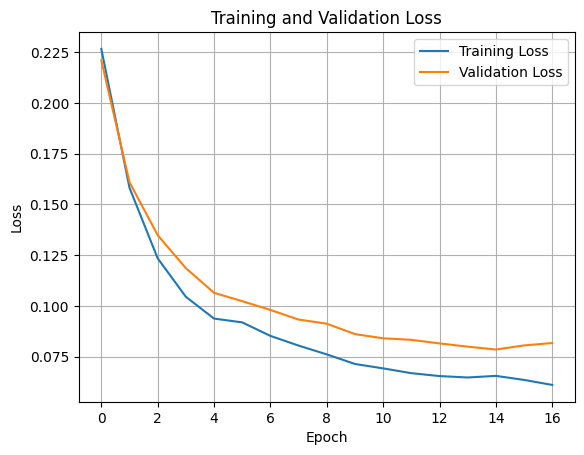


Training complete. Running test...
Test Loss: 0.0600, R^2 Score: 0.9953
Max Volt: 11.3461, Min Volt: -12.4000


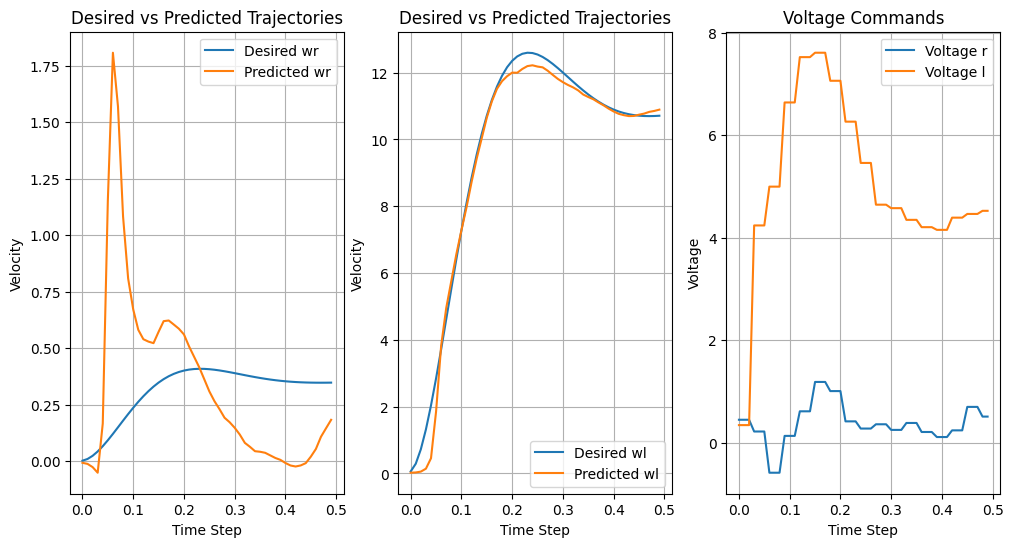

In [ ]:
# Main execution block: Initialize, train, and test the closed-loop system
set_seed(42)
system = Closed_Loop_System('/content/drive/MyDrive/Neural_Network_Controller.pth')
#system = Closed_Loop_System()

print("Starting training with early stopping...")
system.train_controller()

system.controller.model.load_state_dict(system.controller.best_model.state_dict())
system.controller.model.eval()
print("\nTraining complete. Running test...")
system.test_controller(50)

Test Loss: 0.0600, R^2 Score: 0.9953
Max Volt: 11.3461, Min Volt: -12.4000


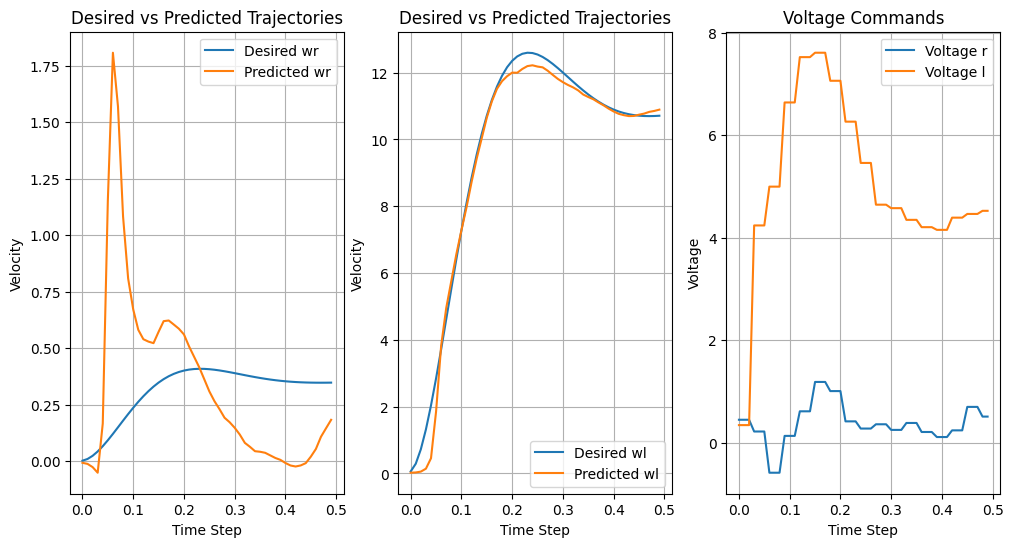

In [ ]:
# Test the controller with a reference length of 500
system.test_controller(50)

Test Loss: 0.0698, R^2 Score: 0.9944
Max Volt: 11.3461, Min Volt: -12.4000


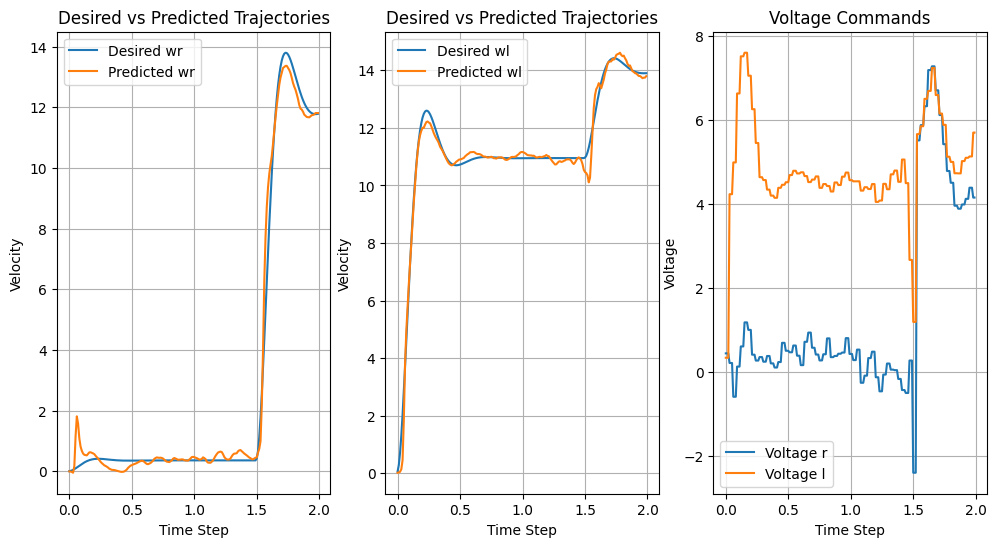

In [ ]:
# Test the controller with a reference length of 200
system.test_controller(200)

Test Loss: 0.0698, R^2 Score: 0.9944
Max Volt: 11.3461, Min Volt: -12.4000


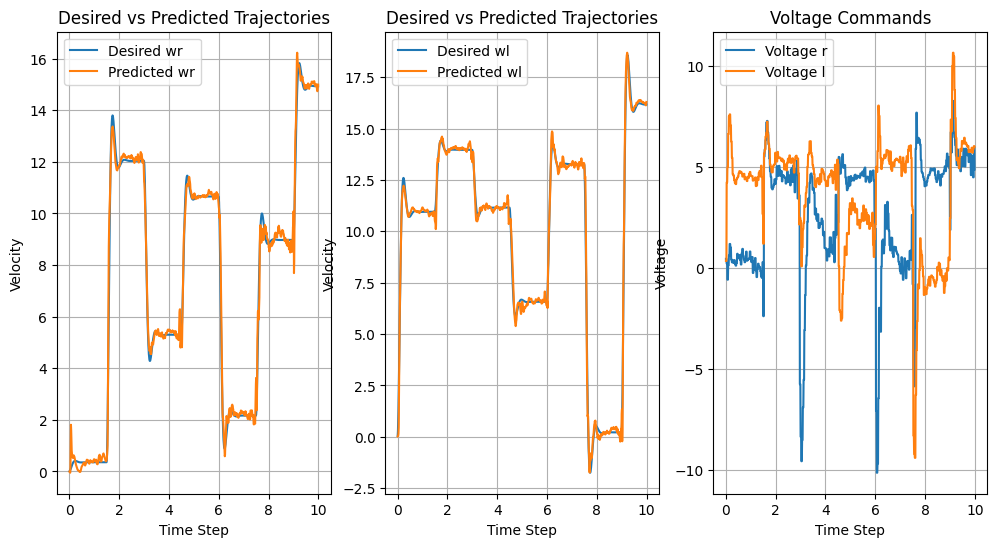

In [ ]:
# Test the controller with a reference length of 1000
system.test_controller(1000)